# Niru's Capstone - Analysis of Best Neighborhoods to Move Into

In [1]:
#importing necessary libraries before beginning data cleaning and analysis
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

import requests 
from pandas.io.json import json_normalize 

import sys
!{sys.executable} --version
!pip install lxml

Python 3.6.10
     |████████████████████████████████| 5.5MB 6.3MB/s eta 0:00:01


In [2]:
#initialize the global variables: US state, two venues of choice, max number of a venue, and max search radius  
US_state = 'Massachusetts'
VENUE_1 = 'Restaurant'
VENUE_2 = 'Gym'
LIMIT = 25
radius = 2000

## Data Importing and Cleaning

### Neighborhood location data

In [3]:
#read in the neighborhood names and zip codes from table, and remove unnecessary columns
df_zip=pd.read_html("https://www.zipcodestogo.com/{}/".format(US_state))[1] #reading in the table of data
df_zip.head()

,0,1,2,3
0,Zip Codes for the State of Massachusetts,Zip Codes for the State of Massachusetts,Zip Codes for the State of Massachusetts,Zip Codes for the State of Massachusetts
1,Zip Code,City,County,Zip Code Map
2,01001,Agawam,Hampden,View Map
3,01002,Amherst,Hampshire,View Map
4,01003,Amherst,Hampshire,View Map


In [4]:
df_zip.drop(inplace=True, axis=0, labels=0) #drop first row
df_zip.rename(columns=df_zip.iloc[0], inplace = True) #this and next line will make new first row the header
df_zip.drop([1], inplace = True)
df_zip.head()

,Zip Code,City,County,Zip Code Map
2,01001,Agawam,Hampden,View Map
3,01002,Amherst,Hampshire,View Map
4,01003,Amherst,Hampshire,View Map
5,01004,Amherst,Hampshire,View Map
6,01005,Barre,Worcester,View Map


In [5]:
df_zip = df_zip.drop(axis=1, labels=['County','Zip Code Map']) #drop the columns that are not required
df_zip.reset_index(inplace = True, drop=True) #reset the index of the dataframe
df_zip.rename(columns={'City':'Neighborhood'}, inplace=True) #renaming column to Neighborhood
df_zip.head()

,Zip Code,Neighborhood
0,01001,Agawam
1,01002,Amherst
2,01003,Amherst
3,01004,Amherst
4,01005,Barre


In [6]:
df_zip.shape

(703, 2)

There are 703 zip codes in Massachusetts

In [7]:
df_zip['Neighborhood'].nunique()

513

There are 513 unique neighborhoods

### House pricing data

In [8]:
#import table of rental data
import requests

rent_url = 'https://www.rentdata.org/states/{}/2020'.format(US_state.lower())

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(rent_url, headers=header)

df_rent = pd.read_html(r.text)
df_rent=df_rent[1]
df_rent.head()

,County,0 BR,1 BR,2 BR,3 BR,4 BR,Est. Population
0,Abington town Metro,"$1,064","$1,160","$1,528","$1,918","$2,240",0
1,Acton town Metro,"$1,715","$1,900","$2,311","$2,880","$3,131",0
2,Acushnet town Metro,$770,$784,$962,"$1,199","$1,303",0
3,Adams town Metro,$669,$815,"$1,026","$1,309","$1,428",0
4,Agawam Town city Metro,$737,$875,"$1,115","$1,389","$1,611",0


In [9]:
#remove the words "town" and "city" from the County names, to allow for merging of dataframes later
df_rent['County'] = df_rent['County'].str.replace('town', '')
df_rent['County'] = df_rent['County'].str.replace('city', '')
df_rent['County'] = df_rent['County'].str.replace('Town', '')
df_rent['County'] = df_rent['County'].str.replace('City', '')
df_rent.head()

,County,0 BR,1 BR,2 BR,3 BR,4 BR,Est. Population
0,Abington Metro,"$1,064","$1,160","$1,528","$1,918","$2,240",0
1,Acton Metro,"$1,715","$1,900","$2,311","$2,880","$3,131",0
2,Acushnet Metro,$770,$784,$962,"$1,199","$1,303",0
3,Adams Metro,$669,$815,"$1,026","$1,309","$1,428",0
4,Agawam Metro,$737,$875,"$1,115","$1,389","$1,611",0


In [10]:
#create a new column "Metro", splitting that from "County" column
#counties that are considered a large metropolitan have the word "Metro" in its name
df_metro = df_rent["County"].str.split(" ", n = 1, expand = True)
df_metro.rename(columns={0:'Community', 1:'Metro'}, inplace=True)
df_metro.head()

,Community,Metro
0,Abington,Metro
1,Acton,Metro
2,Acushnet,Metro
3,Adams,Metro
4,Agawam,Metro


In [11]:
#only keepting rental data for 1 BR from df_rent, as that is what I am interested in
df_rent.drop(['0 BR', '2 BR', '3 BR', '4 BR','Est. Population'], axis=1, inplace = True)
df_rent = pd.concat([df_rent, df_metro], axis=1, sort=False) #merging the two dataframes, df_rent and df_metro
df_rent.head()

,County,1 BR,Community,Metro
0,Abington Metro,"$1,160",Abington,Metro
1,Acton Metro,"$1,900",Acton,Metro
2,Acushnet Metro,$784,Acushnet,Metro
3,Adams Metro,$815,Adams,Metro
4,Agawam Metro,$875,Agawam,Metro


In [12]:
df_rent.shape

(351, 4)

In [13]:
#clean up the new dataframe
df_rent.drop('County',axis=1, inplace = True) #drop column "County"
df_rent.head()

,1 BR,Community,Metro
0,"$1,160",Abington,Metro
1,"$1,900",Acton,Metro
2,$784,Acushnet,Metro
3,$815,Adams,Metro
4,$875,Agawam,Metro


In [14]:
#delete non-Metro neighborhoods and change column name to Neighborhood
df_rent.rename(columns={'Community':'Neighborhood'}, inplace=True) #change column name to Neighborhood from Community
df_rent['Metro'].replace('', np.nan, inplace=True) #replace empty cells in Metro with NaN
df_rent.dropna(subset=['Metro'], inplace=True) #dropping rows with NaN value in Metro column
df_rent.head()

,1 BR,Neighborhood,Metro
0,"$1,160",Abington,Metro
1,"$1,900",Acton,Metro
2,$784,Acushnet,Metro
3,$815,Adams,Metro
4,$875,Agawam,Metro


In [15]:
df_rent.shape

(321, 3)

321 neighborhoods exist now - previously there were 351

### Safety data

In [16]:
#read in table of safety data
df_table=pd.read_html("https://www.safewise.com/blog/safest-cities-{}/".format(US_state.lower()))[0]
df_table.head()

,0,1,2,3,4
0,2020 Ranking,City,Population,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
1,21,Melrose,28552,0.5,5.1
2,22,Concord,19459,0.4,5.7
3,23,Northborough,15124,0,7.3
4,24,Duxbury,16049,0.4,5.7


In [17]:
#make the first row the header
df_table = df_table.T.set_index(0).T
df_table.head()

,2020 Ranking,City,Population,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
1,21,Melrose,28552,0.5,5.1
2,22,Concord,19459,0.4,5.7
3,23,Northborough,15124,0,7.3
4,24,Duxbury,16049,0.4,5.7
5,25,Grafton,18900,1.1,3.2


In [18]:
#scrape in data for the first 20 cities from the infographics
#start with importing libraries 
import urllib.request
url = "https://www.safewise.com/blog/safest-cities-{}/".format(US_state.lower())
page = urllib.request.urlopen(url)
get_ipython().system(u' pip install beautifulsoup4')
from bs4 import BeautifulSoup

     |████████████████████████████████| 122kB 6.3MB/s eta 0:00:01


In [19]:
soup = BeautifulSoup(page, "lxml")
soup.title.string

"Massachusetts's 20 Safest Cities of 2020 | SafeWise"

In [20]:
#scraping was effective as seen above
#start with creating list of neighborhoods
Neighborhood=[]

neighs=soup.find_all('div', class_='cell ranking-component__masthead-name')

for element in neighs:
    cells=element.find_all('p')
    if len(cells)==1:
        Neighborhood.append(cells[0].find(text=True))
        
Neighborhood

['Hopkinton',
 'Franklin',
 'Shrewsbury',
 'Milton',
 'Norton',
 'Lexington',
 'Westford',
 'Andover',
 'Sharon',
 'Wellesley',
 'Holliston',
 'Winchester',
 'Bedford',
 'Reading',
 'Scituate',
 'Needham',
 'North Reading',
 'Belmont',
 'Arlington',
 'Billerica']

In [21]:
#repeat this process for safety ranking, PC rates, and VC rates
#safety ranking scraping
rank=soup.find_all('div', class_='cell ranking-component__masthead-rank')

Safety_Rankings=[]

for element in rank:
    cells=element.find_all('p')
    if len(cells)==1:
        Safety_Rankings.append(cells[0].find(text=True))
        
Safety_Rankings

['#1',
 '#2',
 '#3',
 '#4',
 '#5',
 '#6',
 '#7',
 '#8',
 '#9',
 '#10',
 '#11',
 '#12',
 '#13',
 '#14',
 '#15',
 '#16',
 '#17',
 '#18',
 '#19',
 '#20']

In [22]:
#PC rates scraping
PC_Rates=[]

pcrates=soup.find_all('div', class_='ranking-component__statistic icon__circle-property')
pcrates

for element in pcrates:
    cells=element.find_all('span', class_='ranking-component__statistic-info select-icon')
    if len(cells)==1:
        PC_Rates.append(cells[0].find(text=True))
        
PC_Rates

['1.6, 3.4, 3.8',
 '2.6, 2.2, 2.9',
 '3.0, 3.5, 4.8',
 '2.2, 7.8, 8.2',
 '1.2, 0.9, 1.7',
 '3.3, Not available, 3.9',
 '2.6, 3.1, 3.7',
 '4.8, 8.0, 6.1',
 '2.8, 2.4, 3.4',
 '4.2, 4.5, 5.5',
 '2.7, 2.0, 3.8',
 '4.9, 5.2, 7.4',
 '4.1, 4.0, 3.4',
 '5.5, 6.0, 6.8',
 '3.4, Not available, Not available',
 '4.6, 6.2, 5.8',
 '2.8, 4.1, 3.8',
 '6.3, 7.9, 6.9',
 '4.2, 5.7, 5.1',
 '3.8, 5.7, 4.7']

In [23]:
#PC rates scraping
vcrates=soup.find_all('div', class_='ranking-component__statistic icon__circle-gun')

VC_Rates=[]

for element in vcrates:
    cells=element.find_all('span', class_='ranking-component__statistic-info select-icon')
    if len(cells)==1:
        VC_Rates.append(cells[0].find(text=True))
        
VC_Rates

['0.1, 0.0, 0.1',
 '0.2, 0.3, 0.0',
 '0.1, 0.1, 0.1',
 '0.4, 0.5, 0.3',
 '0.7, 0.1, 0.5',
 '0.2, Not available, 0.7',
 '0.5, 0.4, 0.9',
 '0.2, 2.0, 0.6',
 '0.7, 0.8, 0.8',
 '0.4, 0.4, 0.4',
 '0.8, 0.5, 0.7',
 '0.3, 0.4, 0.2',
 '0.5, 0.6, 0.4',
 '0.2, 0.3, 0.4',
 '0.8, Not available, Not available',
 '0.5, 0.3, 0.2',
 '1.0, 1.5, 1.3',
 '0.2, 0.5, 0.5',
 '0.7, 0.8, 1.2',
 '0.8, 0.9, 1.0']

In [24]:
#create dataframes from scraped lists
#start with Neighborhoods
df_neigh=pd.DataFrame(Neighborhood,columns=['Neighborhood'])
df_neigh.head()

,Neighborhood
0,Hopkinton
1,Franklin
2,Shrewsbury
3,Milton
4,Norton


In [25]:
#repeat process for safety rankings, VC rates, and PC rates
df_saferank=pd.DataFrame(Safety_Rankings,columns=['Safety Ranking'])
df_vc=pd.DataFrame(VC_Rates,columns=['VC Rates'])
df_pc=pd.DataFrame(PC_Rates,columns=['PC Rates'])
df_saferank.head()

,Safety Ranking
0,#1
1,#2
2,#3
3,#4
4,#5


In [26]:
#remove number sign
df_saferank['Safety Ranking'] = df_saferank['Safety Ranking'].str.replace('#', '')
df_saferank.head()

,Safety Ranking
0,1
1,2
2,3
3,4
4,5


In [27]:
df_vc.head()

,VC Rates
0,"0.1, 0.0, 0.1"
1,"0.2, 0.3, 0.0"
2,"0.1, 0.1, 0.1"
3,"0.4, 0.5, 0.3"
4,"0.7, 0.1, 0.5"


In [28]:
#split into three columns for years 2020, 2019 and 2018
df_vc = df_vc["VC Rates"].str.split(",", n = 3, expand = True)
df_vc.head()

,0,1,2
0,0.1,0.0,0.1
1,0.2,0.3,0.0
2,0.1,0.1,0.1
3,0.4,0.5,0.3
4,0.7,0.1,0.5


In [29]:
#keep only the first column (year 2020) and rename it to Violent Crime (per 1,000)
df_vc = df_vc.drop(axis=1, labels=[1,2]) 
df_vc.rename(columns={0:'Violent Crime (per 1,000)'}, inplace=True)
df_vc.head()

,"Violent Crime (per 1,000)"
0,0.1
1,0.2
2,0.1
3,0.4
4,0.7


In [30]:
#repeat this process for PC rates
df_pc = df_pc["PC Rates"].str.split(",", n = 3, expand = True)
df_pc = df_pc.drop(axis=1, labels=[1,2]) 
df_pc.rename(columns={0:'Property Crime (per 1,000)'}, inplace=True)
df_pc.head()

,"Property Crime (per 1,000)"
0,1.6
1,2.6
2,3.0
3,2.2
4,1.2


In [31]:
#combine the scraped dataframes, side by side
df_safety_scraped = pd.concat([df_saferank, df_neigh, df_vc, df_pc], axis=1)
df_safety_scraped.head()

,Safety Ranking,Neighborhood,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
0,1,Hopkinton,0.1,1.6
1,2,Franklin,0.2,2.6
2,3,Shrewsbury,0.1,3.0
3,4,Milton,0.4,2.2
4,5,Norton,0.7,1.2


In [32]:
#make edits to original imported table of the remaining neighborhoods such that it matches df_safety_scraped
df_table.head()

,2020 Ranking,City,Population,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
1,21,Melrose,28552,0.5,5.1
2,22,Concord,19459,0.4,5.7
3,23,Northborough,15124,0,7.3
4,24,Duxbury,16049,0.4,5.7
5,25,Grafton,18900,1.1,3.2


In [33]:
#drop population column, change city to neighborhood
df_table.drop(['Population'], axis=1, inplace = True)
df_table.rename(columns={'City':'Neighborhood','2020 Ranking':'Safety Ranking'}, inplace=True)
df_table.head()

,Safety Ranking,Neighborhood,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
1,21,Melrose,0.5,5.1
2,22,Concord,0.4,5.7
3,23,Northborough,0,7.3
4,24,Duxbury,0.4,5.7
5,25,Grafton,1.1,3.2


In [34]:
#combine df_table with the table of scraped info for top 20 safest neighborhoods
df_safety = pd.concat([df_safety_scraped, df_table])
df_safety.shape

(139, 4)

There are 139 rows as expected

Before moving on to the Foursquare data, let's combine the zip code, housing, and safety dataframes based on the neighborhoods such that we are making fewer calls on Foursquare

In [35]:
df_merge = pd.merge(df_zip, df_rent, on=["Neighborhood"]) #merging the df's with neighborhoods
df_total = pd.merge(df_merge, df_safety, on=["Neighborhood"])
df_total.shape

(283, 7)

In [36]:
df_total.head()

,Zip Code,Neighborhood,1 BR,Metro,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
0,01001,Agawam,$875,Metro,113,3.6,14.8
1,01002,Amherst,$875,Metro,64,3,4.3
2,01003,Amherst,$875,Metro,64,3,4.3
3,01004,Amherst,$875,Metro,64,3,4.3
4,01027,Easthampton,$875,Metro,63,2.1,7.6


In [37]:
#Metro column is no longer needed
df_total.drop(['Metro'], axis=1, inplace = True)
df_total.head()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
0,01001,Agawam,$875,113,3.6,14.8
1,01002,Amherst,$875,64,3,4.3
2,01003,Amherst,$875,64,3,4.3
3,01004,Amherst,$875,64,3,4.3
4,01027,Easthampton,$875,63,2.1,7.6


In [38]:
df_total.tail()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
278,02771,Seekonk,$898,100,1.6,16.9
279,02777,Swansea,$898,79,1.7,11.6
280,02780,Taunton,$953,98,4.2,6.2
281,02783,Taunton,$953,98,4.2,6.2
282,02790,Westport,$898,62,2.1,7.2


### Foursquare Venue data

In [39]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

In [48]:
CLIENT_ID = 'C1DJSVQPIID5XJCYEBF3UJC2USPHCLQDDFCWPTSO45TB4EKE' 
CLIENT_SECRET = 'V1PQLRD0XKUJR5IGKDANZ3QSSWYWUMZJS4HUNAE2JU30LUJM' 
VERSION = '20180604'
LIMIT = 30

In [65]:
#create list of all zipcodes
zipcodes = df_total['Zip Code']
zipcodes.head()

0    01001
1    01002
2    01003
3    01004
4    01027
Name: Zip Code, dtype: object

In [42]:
#create a list of latitude and longitude points for each zipcode
Location=[]
No_location_info=[]
for zipcode in zipcodes:
    geolocator = Nominatim(user_agent="geoapiExercises")
    zipcode1 = zipcode + ", USA"
    location = geolocator.geocode(zipcode1)
    if hasattr(location, 'latitude'): #unfortunately foursquare cannot get location data for all zipcodes, so if statement creates list of zipcodes that could not be processed
        latitude = location.latitude
        longitude = location.longitude
        coord = latitude, longitude
        Location.append(coord)
    else: 
        No_location_info.append(zipcode)

In [43]:
No_location_info

['01133',
 '01138',
 '01152',
 '01195',
 '01203',
 '01580',
 '01582',
 '01614',
 '01704',
 '01705',
 '01813',
 '01812',
 '05544',
 '01822',
 '01831',
 '01853',
 '01931',
 '01961',
 '01971',
 '02117',
 '02123',
 '02196',
 '02204',
 '02207',
 '02211',
 '02216',
 '02217',
 '02241',
 '02239',
 '02185',
 '02304']

In [49]:
#use the list of lat and long data to create a list of unique Foursquare url's for each zip code
#create the url's for venue 1 (restaurant)
url_table1=[]
for coordinates in Location:
    latitude = coordinates[0]
    longitude = coordinates[1]
    url1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, VENUE_1, radius, LIMIT)
    url_table1.append(url1)


In [53]:
url_table1[0]

'https://api.foursquare.com/v2/venues/search?client_id=C1DJSVQPIID5XJCYEBF3UJC2USPHCLQDDFCWPTSO45TB4EKE&client_secret=V1PQLRD0XKUJR5IGKDANZ3QSSWYWUMZJS4HUNAE2JU30LUJM&ll=42.06726175158752,-72.62537420928858&v=20180604&query=Restaurant&radius=2000&limit=30'

In [51]:
#create the url's for venue 2 (gym)
url_table2=[]
for coordinates in Location:
    latitude = coordinates[0]
    longitude = coordinates[1]
    url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, VENUE_2, radius, LIMIT)
    url_table2.append(url2)

In [55]:
#now grab the number of venues for each category
#start with venue 1, find the number of restaurants for each url/zipcode
num_rest=[]
for url in url_table1:
    results1 = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results1['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    num_rest.append(dataframe.shape[0])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':


In [56]:
num_rest[0:10]

[12, 9, 9, 9, 0, 14, 0, 10, 2, 15]

In [57]:
#do the same for venue 2, number of gyms in each zip code
num_gym=[]
for url in url_table2:
    results2 = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results2['response']['venues']
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    num_gym.append(dataframe.shape[0])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [58]:
num_gym[0:10]

[1, 6, 4, 7, 1, 2, 0, 0, 2, 3]

In [59]:
#transform the data into a dataframe for each venue category
#do this for restaurants first
number_rest = pd.DataFrame(num_rest, columns=['Number of Restaurants'])
number_rest.head(15)

,Number of Restaurants
0,12
1,9
2,9
3,9
4,0
5,14
6,0
7,10
8,2
9,15


In [60]:
number_rest.shape

(252, 1)

In [61]:
#now do it for gyms
number_gyms = pd.DataFrame(num_gym, columns=['Number of Gyms'])
number_gyms.head(15)

,Number of Gyms
0,1
1,6
2,4
3,7
4,1
5,2
6,0
7,0
8,2
9,3


In [62]:
number_gyms.shape

(252, 1)

In [63]:
#delete rows from df_total where url could not be created
df_zips_wvenues=df_total

for city in No_location_info:
    df_zips_wvenues.drop(df_zips_wvenues.index[df_zips_wvenues['Zip Code'] == city], inplace = True)

In [64]:
df_zips_wvenues.shape

(252, 6)

In [73]:
df_zips_wvenues.head()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)"
0,01001,Agawam,$875,113,3.6,14.8
1,01002,Amherst,$875,64,3,4.3
2,01003,Amherst,$875,64,3,4.3
3,01004,Amherst,$875,64,3,4.3
4,01027,Easthampton,$875,63,2.1,7.6


In [146]:
#concat these two dataframes (rest and gyms) into df_total to create a dataframe of all relevant data
df_final = pd.concat([df_zips_wvenues, number_rest, number_gyms],axis=1)
df_final.head()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
0,01001,Agawam,$875,113,3.6,14.8,12.0,1.0
1,01002,Amherst,$875,64,3,4.3,9.0,6.0
2,01003,Amherst,$875,64,3,4.3,9.0,4.0
3,01004,Amherst,$875,64,3,4.3,9.0,7.0
4,01027,Easthampton,$875,63,2.1,7.6,0.0,1.0


In [147]:
#drop the rows with either restaurants or no gyms
df_final['Number of Restaurants'].replace(0.0, np.nan, inplace=True) #replace zero cells with NaN
df_final['Number of Gyms'].replace(0.0, np.nan, inplace=True)
df_final.dropna(subset=['Number of Restaurants'], inplace=True) #dropping rows with NaN value in Metro column
df_final.dropna(subset=['Number of Gyms'], inplace=True)

In [159]:
df_final.dropna(subset=None, axis=0, inplace=True)
df_final.reset_index(drop=True, inplace=True)

In [160]:
df_final.head()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
0,01001,Agawam,$875,113,3.6,14.8,12.0,1.0
1,01002,Amherst,$875,64,3,4.3,9.0,6.0
2,01003,Amherst,$875,64,3,4.3,9.0,4.0
3,01004,Amherst,$875,64,3,4.3,9.0,7.0
4,01040,Holyoke,$875,139,9.7,40.5,14.0,2.0


In [161]:
df_final.shape

(159, 8)

In [177]:
df_final.dtypes

Zip Code                       object
Neighborhood                   object
1 BR                           object
Safety Ranking                 object
Violent Crime (per 1,000)      object
Property Crime (per 1,000)     object
Number of Restaurants         float64
Number of Gyms                float64
dtype: object

In [178]:
#convert all columns to their appropriate types
df_final['1 BR'] = df_final['1 BR'].str.replace('$', '')
df_final['1 BR'] = df_final['1 BR'].str.replace(',', '')
df_final['1 BR'] = df_final['1 BR'].astype(int)
df_final[['Safety Ranking', 'Number of Restaurants','Number of Gyms']] = df_final[['Safety Ranking', 'Number of Restaurants','Number of Gyms']].astype(int)
df_final[['Violent Crime (per 1,000)', 'Property Crime (per 1,000)']] = df_final[['Violent Crime (per 1,000)', 'Property Crime (per 1,000)']].astype(float)
df_final.dtypes

Zip Code                       object
Neighborhood                   object
1 BR                            int64
Safety Ranking                  int64
Violent Crime (per 1,000)     float64
Property Crime (per 1,000)    float64
Number of Restaurants           int64
Number of Gyms                  int64
dtype: object

## Data Analysis and Machine Learning

In [82]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



Let's do some simple analysis. Price is one of the factors that people care about the most when relocating. Let's call this the dependent variable and see how much each of the other variables (ie. safety) might correlate with price. The hypothesis right now is that neighborhoods that are safer or have high number of venues will be more expensive. Seeing these correlations might give some insight into what the neighborhood clusters may look like.

In [179]:
df_analysis = df_final[['Neighborhood','1 BR', 'Safety Ranking', 'Violent Crime (per 1,000)','Property Crime (per 1,000)','Number of Restaurants','Number of Gyms']]
df_analysis.head()

,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
0,Agawam,875,113,3.6,14.8,12,1
1,Amherst,875,64,3.0,4.3,9,6
2,Amherst,875,64,3.0,4.3,9,4
3,Amherst,875,64,3.0,4.3,9,7
4,Holyoke,875,139,9.7,40.5,14,2


In [180]:
#will use df_analysis to perform some rudimentary analysis of the data to attempt to find correlations
df_analysis.dtypes

Neighborhood                   object
1 BR                            int64
Safety Ranking                  int64
Violent Crime (per 1,000)     float64
Property Crime (per 1,000)    float64
Number of Restaurants           int64
Number of Gyms                  int64
dtype: object

In [181]:
#group by Neighborhood to make the exploratory data analysis easier
df_grouped = df_analysis.groupby('Neighborhood').agg({'Safety Ranking': 'mean', '1 BR': 'mean','Number of Restaurants': 'sum','Number of Gyms': 'sum'})
df_grouped.head()

,Safety Ranking,1 BR,Number of Restaurants,Number of Gyms
Neighborhood,,,,
Agawam,113,875,12,1
Amesbury,60,1900,3,1
Amherst,64,875,27,17
Andover,8,1117,64,19
Ashland,35,1900,9,9


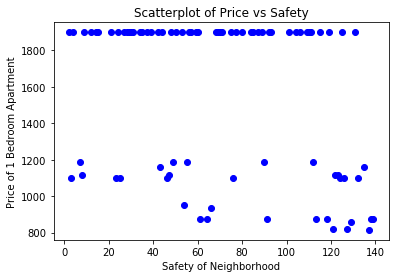

In [265]:
#scatterplot of price vs safety
import matplotlib.pyplot as plt
plt.scatter(df_grouped['Safety Ranking'], df_grouped['1 BR'],  color='blue') 
plt.title('Scatterplot of Price vs Safety')
plt.xlabel("Safety of Neighborhood")
plt.ylabel("Price of 1 Bedroom Apartment")
plt.savefig('price_vs_safety.jpg')
plt.show()


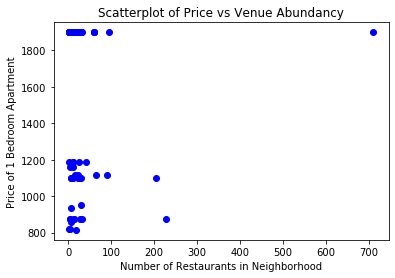

In [266]:
#scatterplot of price vs number of venues
plt.scatter(df_grouped['Number of Restaurants'], df_grouped['1 BR'],  color='blue') 
plt.title('Scatterplot of Price vs Venue Abundancy')
plt.xlabel("Number of Restaurants in Neighborhood")
plt.ylabel("Price of 1 Bedroom Apartment")
plt.savefig('price_vs_venue.jpg')
plt.show()


There appears to be an outlier, however it is a result of aggregating the neighborhoods, so we will not eliminate it as we normally would.

In [184]:
#get coordinates for the US state
geolocator = Nominatim(user_agent="to_explorer")
state_location = geolocator.geocode(US_state)
state_latitude = location.latitude
state_longitude = location.longitude

In [151]:
#add latitude and longitude data to df_final
latlong=[]

for zipcode in df_final['Zip Code']:
    geolocator = Nominatim(user_agent="geoapiExercises")
    zipcode1 = zipcode + ", USA"
    location = geolocator.geocode(zipcode1)
    latitude = location.latitude
    longitude = location.longitude
    coord = latitude, longitude
    latlong.append(coord)

In [185]:
len(latlong)

159

In [186]:
#convert the list into a df that can be combined with df_final
Lat_Long = pd.DataFrame(latlong, columns=['Latitude','Longitude'])
print(Lat_Long.shape)

(159, 2)


In [187]:
df_final.head()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
0,01001,Agawam,875,113,3.6,14.8,12,1
1,01002,Amherst,875,64,3.0,4.3,9,6
2,01003,Amherst,875,64,3.0,4.3,9,4
3,01004,Amherst,875,64,3.0,4.3,9,7
4,01040,Holyoke,875,139,9.7,40.5,14,2


In [188]:
M = pd.concat([df_final, Lat_Long], axis=1, sort=False)
M.head()

,Zip Code,Neighborhood,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms,Latitude,Longitude
0,01001,Agawam,875,113,3.6,14.8,12,1,42.067262,-72.625374
1,01002,Amherst,875,64,3.0,4.3,9,6,42.381409,-72.518025
2,01003,Amherst,875,64,3.0,4.3,9,4,42.390126,-72.526683
3,01004,Amherst,875,64,3.0,4.3,9,7,42.376725,-72.520344
4,01040,Holyoke,875,139,9.7,40.5,14,2,42.203372,-72.624506


In [189]:
M.dtypes

Zip Code                       object
Neighborhood                   object
1 BR                            int64
Safety Ranking                  int64
Violent Crime (per 1,000)     float64
Property Crime (per 1,000)    float64
Number of Restaurants           int64
Number of Gyms                  int64
Latitude                      float64
Longitude                     float64
dtype: object

In [191]:
df_final.describe()

,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,1533.584906,94.320755,4.135220,14.391824,16.729560,9.308176
std,444.337742,42.453746,2.848898,7.129977,11.367111,10.242595
min,815.000000,2.000000,0.000000,2.200000,1.000000,1.000000
25%,1100.000000,58.000000,1.450000,8.850000,5.000000,2.000000
50%,1900.000000,112.000000,3.700000,13.700000,15.000000,5.000000
75%,1900.000000,131.000000,6.200000,20.200000,30.000000,11.000000
max,1900.000000,139.000000,9.900000,40.500000,30.000000,30.000000


In [193]:
#start clustering the neighborhoods
# set number of clusters
kclusters = 6 

df_train = df_final.drop('Neighborhood', 1) #drop unwanted data like lat/long, hood name, zip code, etc

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_train)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 5], dtype=int32)

In [220]:
# add clustering labels to the dataframe df_final
cluster_num = pd.DataFrame(kmeans.labels_,columns=['Cluster Number'])
cluster_num.head()

,Cluster Number
0,1
1,1
2,1
3,1
4,1


In [229]:
cluster_num.shape

(159, 1)

In [231]:
#final dataframe with all relevant information
df_final.head()

,Zip Code,Neighborhood,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
0,01001,Agawam,1,875,113,3.6,14.8,12,1
1,01002,Amherst,1,875,64,3.0,4.3,9,6
2,01003,Amherst,1,875,64,3.0,4.3,9,4
3,01004,Amherst,1,875,64,3.0,4.3,9,7
4,01040,Holyoke,1,875,139,9.7,40.5,14,2


In [234]:
#cluster 1
clust1 = df_final.loc[df_final['Cluster Number'] == 1]
clust1.describe()

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,24.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,1.0,868.666667,119.250000,6.887500,21.054167,14.333333,3.666667
std,0.0,17.130361,28.067078,3.231275,9.008401,9.177793,2.200132
min,1.0,815.000000,61.000000,0.900000,4.300000,2.000000,1.000000
25%,1.0,875.000000,116.750000,3.900000,17.650000,8.750000,2.000000
50%,1.0,875.000000,137.000000,8.400000,26.400000,13.500000,3.500000
75%,1.0,875.000000,138.000000,9.900000,26.400000,19.000000,5.250000
max,1.0,875.000000,139.000000,9.900000,40.500000,30.000000,7.000000


In [235]:
#cluster 2
clust2 = df_final.loc[df_final['Cluster Number'] == 2]
clust2.describe()

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,20.0,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000
mean,2.0,1140.100000,85.100000,3.655000,11.54000,14.750000,3.650000
std,0.0,54.800019,45.858937,2.825723,5.17925,10.949045,6.368301
min,2.0,953.000000,7.000000,0.200000,2.60000,1.000000,1.000000
25%,2.0,1117.000000,48.500000,1.200000,8.65000,5.500000,1.000000
50%,2.0,1138.500000,112.000000,3.200000,11.60000,11.500000,2.000000
75%,2.0,1188.000000,122.250000,5.750000,14.32500,26.250000,4.000000
max,2.0,1188.000000,135.000000,9.000000,21.60000,30.000000,30.000000


In [236]:
#cluster 3
clust3 = df_final.loc[df_final['Cluster Number'] == 3]
clust3.describe()

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,3.0,1117.0,8.0,0.2,4.8,30.0,12.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.0,1117.0,8.0,0.2,4.8,30.0,12.0
25%,3.0,1117.0,8.0,0.2,4.8,30.0,12.0
50%,3.0,1117.0,8.0,0.2,4.8,30.0,12.0
75%,3.0,1117.0,8.0,0.2,4.8,30.0,12.0
max,3.0,1117.0,8.0,0.2,4.8,30.0,12.0


In [237]:
#cluster 4
clust4 = df_final.loc[df_final['Cluster Number'] == 4]
clust4.describe()

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,28.0,28.0,28.000000,28.000000,28.000000,28.000000,28.000000
mean,4.0,1900.0,73.642857,2.482143,10.139286,11.785714,5.892857
std,0.0,0.0,37.439546,1.947278,3.790567,9.639261,7.435347
min,4.0,1900.0,12.000000,0.200000,4.900000,1.000000,1.000000
25%,4.0,1900.0,42.250000,1.150000,6.625000,4.000000,1.000000
50%,4.0,1900.0,71.500000,1.500000,10.550000,9.000000,4.000000
75%,4.0,1900.0,105.250000,3.500000,13.700000,14.250000,7.000000
max,4.0,1900.0,125.000000,6.000000,18.900000,30.000000,30.000000


In [238]:
#cluster 5
clust5 = df_final.loc[df_final['Cluster Number'] == 5]
clust5.describe()

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,5.0,1065.380952,104.238095,4.914286,16.195238,15.190476,6.666667
std,0.0,89.568117,44.113382,2.635770,6.717773,11.517895,5.850926
min,5.0,818.000000,3.000000,0.000000,3.000000,1.000000,1.000000
25%,5.0,1100.000000,76.000000,2.100000,11.100000,5.000000,1.000000
50%,5.0,1100.000000,132.000000,6.800000,21.400000,10.000000,6.000000
75%,5.0,1100.000000,132.000000,6.800000,21.400000,30.000000,11.000000
max,5.0,1100.000000,132.000000,6.800000,21.400000,30.000000,21.000000


In [241]:
#cluster 0
clust0 = df_final.loc[df_final['Cluster Number'] == 0]
clust0.describe()

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
count,65.0,65.0,65.000000,65.000000,65.000000,65.000000,65.000000
mean,0.0,1900.0,94.984615,3.787692,14.206154,20.646154,15.415385
std,0.0,0.0,41.793949,2.339104,6.210724,11.802318,11.994650
min,0.0,1900.0,2.000000,0.100000,2.200000,1.000000,1.000000
25%,0.0,1900.0,59.000000,1.500000,9.000000,6.000000,4.000000
50%,0.0,1900.0,110.000000,3.700000,13.300000,30.000000,11.000000
75%,0.0,1900.0,131.000000,6.200000,20.200000,30.000000,30.000000
max,0.0,1900.0,131.000000,6.200000,20.200000,30.000000,30.000000


In [258]:
#combine the mean data of each cluster and compare with the average data of the entire dataset
summary_mean=[(clust0.describe()).iloc[1],
              (clust1.describe()).iloc[1],
              (clust2.describe()).iloc[1],
              (clust3.describe()).iloc[1],
              (clust4.describe()).iloc[1],
              (clust5.describe()).iloc[1],
             (df_final.describe()).iloc[1]]
              
summary_clus = pd.DataFrame(summary_mean)
summary_clus

,Cluster Number,1 BR,Safety Ranking,"Violent Crime (per 1,000)","Property Crime (per 1,000)",Number of Restaurants,Number of Gyms
mean,0.000000,1900.000000,94.984615,3.787692,14.206154,20.646154,15.415385
mean,1.000000,868.666667,119.250000,6.887500,21.054167,14.333333,3.666667
mean,2.000000,1140.100000,85.100000,3.655000,11.540000,14.750000,3.650000
mean,3.000000,1117.000000,8.000000,0.200000,4.800000,30.000000,12.000000
mean,4.000000,1900.000000,73.642857,2.482143,10.139286,11.785714,5.892857
mean,5.000000,1065.380952,104.238095,4.914286,16.195238,15.190476,6.666667
mean,1.786164,1533.584906,94.320755,4.135220,14.391824,16.729560,9.308176


In [261]:
#export tables that will be useful for the report
summary_clus.to_csv("cluster_summary.csv")

In [262]:
df_final.to_csv('final_table.csv')